In [67]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import copy

from pointcloud_tools import PointCloudCreator #, create_pcd_from_array, read_pcd, write_pcd

from skimage.util import img_as_float
from skimage.util import img_as_ubyte

In [101]:
SUBSTRATE_LEVEL = {
    "A": 10,
    "B": 7,
    "C": 10,
    "D": 10,
}

In [68]:
def threshold_image(img_in, thres):
    """
    Apply a threshold in an image and return the resulting image
    :param img_in: Input image
    :param thres: The treshold value in the range [0, 255]
    :return: Resulting image (unsigned byte) where background is 0 and foreground is 255
    """

    background = img_in < thres
    foreground = img_in > thres

    mask = img_in > thres

    return img_as_ubyte(mask)

In [69]:
# point to the data dir
current_folder = Path(".").resolve()
base_dir = current_folder.parent / "data"

## Data Loader

In [70]:
# point to the image files
image = "A_1a111b40"            #A_1a111b40 B_0328ab97 B_93dd57ad  D_b14ffae7

rgb_file = base_dir / "rgb" / f"{image}.png"
depth_file = base_dir / "depth" / f"{image}_depth.png"

## Visualization

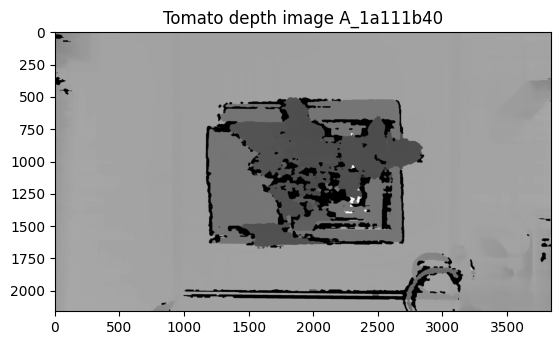

In [71]:
# The depth image is provided by the camera, and is a reconstruction from stero infra-red imaging.
depth_img = cv2.imread(str(depth_file), cv2.IMREAD_UNCHANGED)
plt.imshow(depth_img, cmap='gray')
plt.title(f"Tomato depth image {image}")
plt.show()

## Pointcloud Creator

In [72]:
# init a point cloud creator with the camera configuration
point_cloud_creator = PointCloudCreator(conf_file=base_dir / "oak-d-s2-poe_conf.json", logger_level=100)

# create pcd object
pcd_object = point_cloud_creator.convert_depth_to_pcd(rgb_file=rgb_file, depth_file=depth_file)

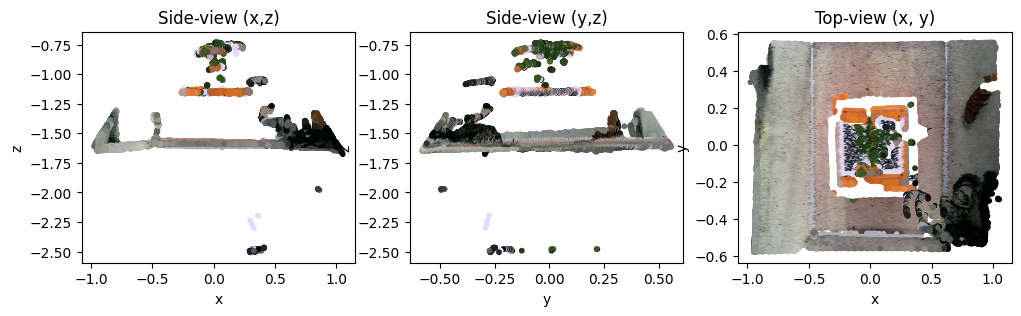

In [73]:
# Extract points and colors
points = np.asarray(pcd_object.points)
colors = np.asarray(pcd_object.colors)

# downsample to make the plotting faster

# use -y because the pixel coordinates differs from the matrix coordinate system
# use -z because the camera is facing downwards
x = copy.deepcopy(points[range(0, len(points), 100), 0])
y = copy.deepcopy(-points[range(0, len(points), 100), 1])
z = copy.deepcopy(-points[range(0, len(points), 100), 2]) 
c = copy.deepcopy(colors[range(0, len(points), 100), :])

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

axs[0].scatter(x, z, c=c, s=10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].set_title('Side-view (x,z)')

axs[1].scatter(y, z, c=c, s=10)
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')
axs[1].set_title('Side-view (y,z)')

axs[2].scatter(x, y, c=c, s=10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Top-view (x, y)')

plt.show()

In [88]:
ground_level = -1.3

# filter out the points that are below the ground level
mask = z > ground_level

x_ground_filtered = x[mask]
y_ground_filtered = y[mask]
z_ground_filtered = z[mask]
c_ground_filtered = c[mask]

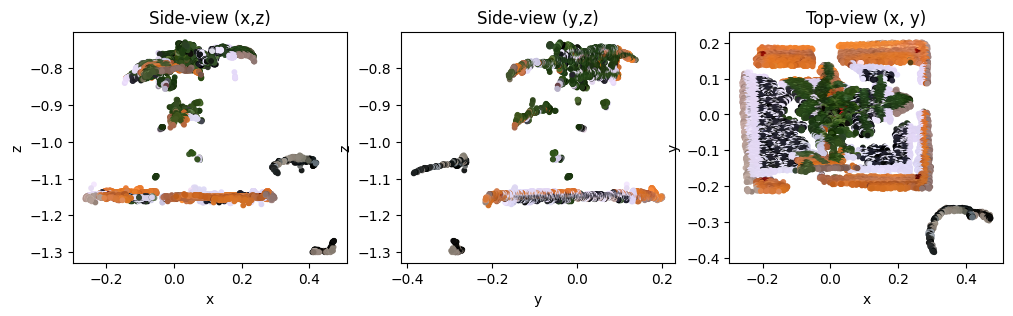

Minimum x position: -0.29810624387933154
Maximum x position: 0.5098442806138768
Minimum z position: -1.3284999489784242
Maximum z position: -0.7015000224113465
X range: 0.8079505244932084
Z range: 0.6269999265670777



In [89]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

axs[0].scatter(x_ground_filtered, z_ground_filtered, c=c_ground_filtered, s=10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].set_title('Side-view (x,z)')

axs[1].scatter(y_ground_filtered, z_ground_filtered, c=c_ground_filtered, s=10)
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')
axs[1].set_title('Side-view (y,z)')

axs[2].scatter(x_ground_filtered, y_ground_filtered, c=c_ground_filtered, s=10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Top-view (x, y)')

plt.show()


x_min, x_max = axs[0].get_xlim()
z_min, z_max = axs[0].get_ylim()
x_range = np.abs(x_max) + np.abs(x_min)
z_range = z_max - z_min
print(f"Minimum x position: {x_min}")
print(f"Maximum x position: {x_max}")
print(f"Minimum z position: {z_min}")
print(f"Maximum z position: {z_max}")
print(f"X range: {x_range}")
print(f"Z range: {z_range}")
print()

plant_max = np.max(z_ground_filtered)

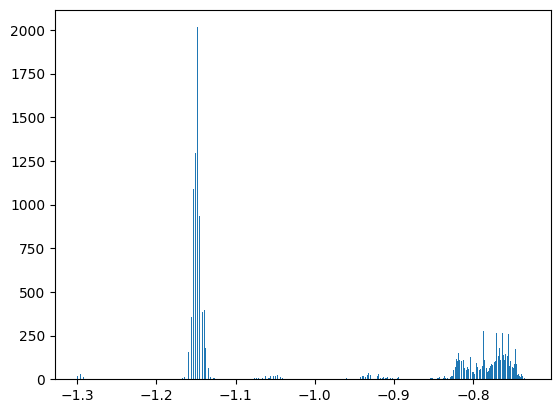

Ground level: 6
Ground level: -1.1498999698956807
Plant top0: -0.7395000179608663
Plant height: 0.3103999519348144


In [109]:
freq, bins = np.histogram(z_ground_filtered, bins=300)
plt.hist(z_ground_filtered, bins=500)
plt.show()

mask = freq > 20
freq = freq[mask]
bins = bins[:-1][mask]

ground_y = np.argmax(freq)          #indize of the most frequent value
print(f"Ground level: {ground_y}")
ground_z = bins[ground_y]
print(f"Ground level: {ground_z}")

plant_top = np.max(bins)
print(f"Plant top0: {plant_top}")

substrat = SUBSTRATE_LEVEL[image[0]]

plant_height = plant_top - ground_z - substrat/100
print(f"Plant height: {plant_height}")

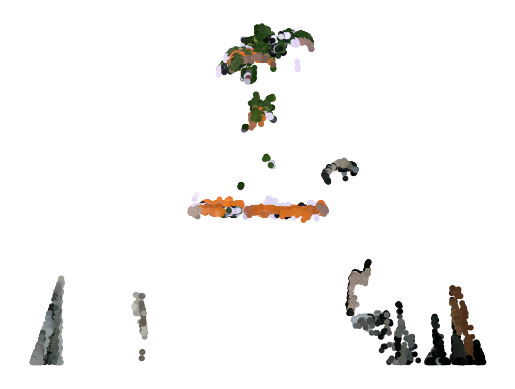

In [77]:
fig, ax = plt.subplots()
ax.scatter(x_ground_filtered, z_ground_filtered, c=c_ground_filtered, s=10)
ax.axis('off')
plt.show()

(480, 640, 3)


/var/folders/lt/dq5vh7md14956h6vnbzt1kmr0000gn/T/ipykernel_65844/1730823473.py:6: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(fig.canvas.get_width_height()[::-1] + (3,))


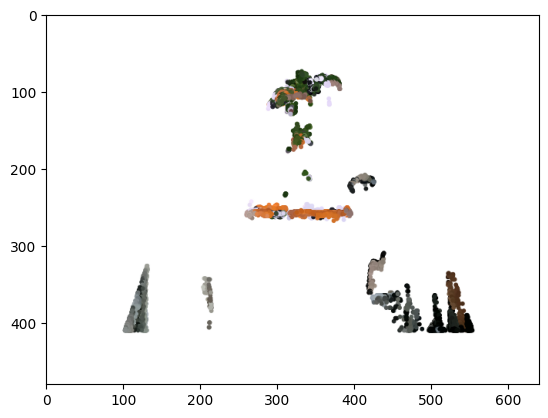

In [78]:
# Render the plot to a buffer
canvas = FigureCanvas(fig)
canvas.draw()

# Retrieve the image from the buffer and convert it to an array
img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(fig.canvas.get_width_height()[::-1] + (3,))
print(img.shape)
plt.imshow(img)
plt.show()

[[-0.81666022 -0.80216012 -0.79858783 ...  0.60018798  0.65055296
   0.77162327]
 [-1.34000003 -1.38999999 -1.46599996 ... -1.43099999 -1.44000006
  -1.49399996]]
[-0.81666022 -0.80216012 -0.79858783 ...  0.60018798  0.65055296
  0.77162327]


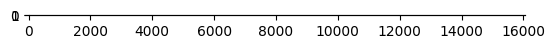

In [79]:
img = np.array([x_ground_filtered, z_ground_filtered])
print(img)
plt.imshow(img)

print(x_ground_filtered)

In [80]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')
plt.show()


img_thres1 = threshold_image(gray_img, 230)
plt.imshow(img_thres1, cmap='gray')
plt.show()

swapped_img = np.where(img_thres1 == 0, 255, 0)
plt.imshow(swapped_img, cmap='gray')
plt.show()

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


Max Y (background): 479
Min Y (background): 0
Max Y (plant): 414
Min Y (plant): 86
Coordinates of min value: (324, 86)
Coordinates of min value: (325, 86)
Coordinates of min value: (326, 86)
Coordinates of min value: (327, 86)
Coordinates of min value: (328, 86)
Coordinates of min value: (329, 86)
Coordinates of min value: (330, 86)
Coordinates of min value: (331, 86)
Coordinates of min value: (332, 86)
Median coordinates of min value: (328.0, 86)


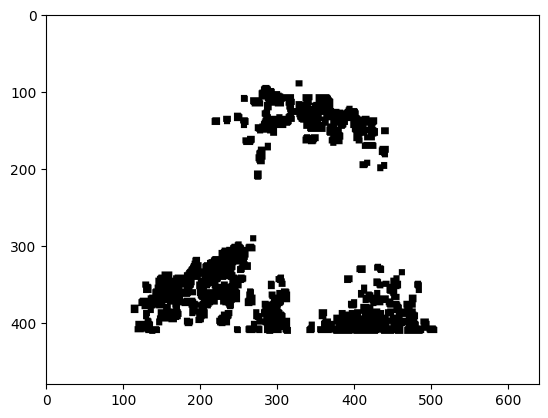

In [ ]:
kernel = np.ones((8, 8), np.uint8)  # define the kernel size for opening
closed_img = cv2.morphologyEx(img_thres1, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed_img, cmap='gray')

img_max = np.max(np.where(closed_img == 255)[0])
img_min = np.min(np.where(closed_img == 255)[0])
print("Max Y (background):", img_max)
print("Min Y (background):", img_min)

max_y = np.max(np.where(closed_img == 0)[0])
min_y = np.min(np.where(closed_img == 0)[0])
plant_pixel = max_y - min_y

print("Max Y (plant):", max_y)
print("Min Y (plant):", min_y)

# Find the x-coordinates where y is max_y and the image is black
x_coords = np.where((closed_img[min_y, :] == 0))[0]

# Now x_coords and max_y give the coordinates of the maximum value
# If you want to print them, you can do something like this:
for x in x_coords:
    print(f"Coordinates of min value: ({x}, {min_y})")

x_coords = np.median(x_coords)
y_coords = min_y

print(f"Median coordinates of min value: ({x_coords}, {y_coords})")

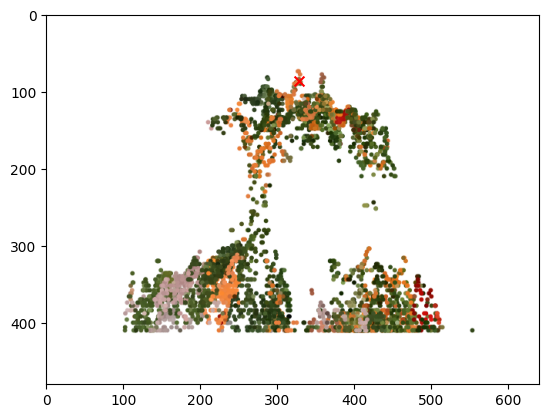

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.scatter(x_coords, y_coords, c='red', s=50, marker='x')
plt.show()

In [ ]:
print(points.shape)

(7576335, 3)


In [ ]:
# Assuming 'src_img' is the source image, 'tgt_img' is the target image,
# and '(src_x, src_y)' are the coordinates in the source image

print(img.shape)
print(x_range)
print(z_range)
print(f"xmin {x_min} xmax {x_max} zmin {z_min} zmax {z_max}")

# Calculate the scale factors
scale_x = (x_range) / (img.shape[1] - 1)
scale_y = (z_range) / (img.shape[0] - 1)

# Calculate the transformed coordinates
tgt_x = x_coords * scale_x
tgt_y = y_coords * scale_y

# Now '(tgt_x, tgt_y)' are the coordinates in the target image
print(f"Coordinates in the target image: ({tgt_x}, {tgt_y})")

tgt_x = x_min + tgt_x
tgt_y = z_max - tgt_y

print(f"Coordinates in the target image: ({tgt_x}, {tgt_y})")


(480, 640, 3)
0.5195369899636083
0.18480004668235772
xmin -0.29041611264986233 xmax 0.22912087731374597 zmin -1.0474000364542007 zmax -0.8625999897718429
Coordinates in the target image: (0.2666793939093326, 0.033179131554661304)
Coordinates in the target image: (-0.02373671874052974, -0.8957791213265043)


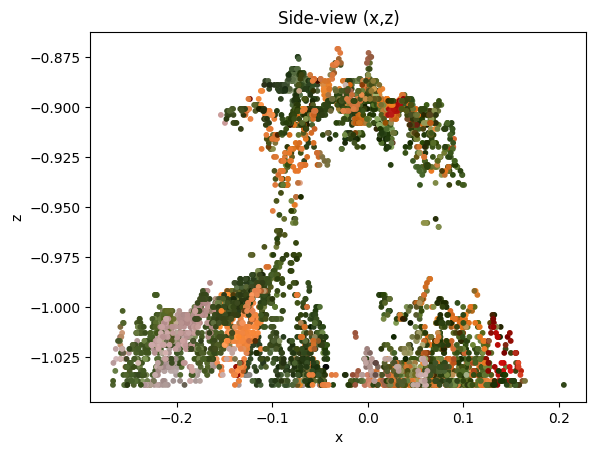

In [ ]:
fig, axs = plt.subplots()

axs.scatter(x_ground_filtered, z_ground_filtered, c=c_ground_filtered, s=10)
axs.set_xlabel('x')
axs.set_ylabel('z')
axs.set_title('Side-view (x,z)')
ax.scatter(-0.2, -0.9, c='red', s=50, marker='x')
plt.show()